# Building machine learning models

Let's build our first basic models for mortality prediction & predicting the hospital length of stay! We previously explored the rich content of the MIMIC database, extracted and preprocessed data so that we could use them in a classifier. Now, we'll build a model for these prediction tasks and evaluate them.

For mortality prediction, which is a binary classification problem, we'll experiment with logistic regression, support, decision trees and random forests.

Hospital length of stay is a regression problem, hence we will use least squares regression and linear ridge regression from the Shogun toolbox.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline

In [68]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [106]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [119]:
query = \
"""
-- Staging table #1: CHARTEVENTS
with ce as
(
  select adm.hadm_id
  , min(case when itemid in (211,220045) and valuenum > 0 then valuenum else null end) as HeartRate_Min
  , max(case when itemid in (211,220045) and valuenum < 300 then valuenum else null end) as HeartRate_Max
  , min(case when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 then valuenum else null end) as MeanBP_Min
  , max(case when itemid in (456,52,6702,443,220052,220181,225312) and valuenum < 300 then valuenum else null end) as MeanBP_Max
  , min(case when itemid in (615,618,220210,224690) and valuenum > 0 then valuenum else null end) as RespRate_Min
  , max(case when itemid in (615,618,220210,224690) and valuenum < 300 then valuenum else null end) as RespRate_Max
  from admissions adm
  left join chartevents chart
    on adm.hadm_id = chart.hadm_id
    and chart.itemid in
    (
    -- HEART RATE
    211, --"Heart Rate"
    220045, --"Heart Rate"

    -- MEAN BLOOD PRESSURE
    456, --"NBP Mean"
    52, --"Arterial BP Mean"
    6702, --Arterial BP Mean #2
    443, --Manual BP Mean(calc)
    220052, --"Arterial Blood Pressure mean"
    220181, --"Non Invasive Blood Pressure mean"
    225312, --"ART BP mean"

    -- RESPIRATORY RATE
    618,--Respiratory Rate
    615,--Resp Rate (Total)
    220210,--Respiratory Rate
    224690 --Respiratory Rate (Total)
    )
  left join icustays ie  
  -- match the tables on the patient identifier
  on ie.icustay_id = chart.icustay_id
  -- and require that the observation be made after the patient is admitted to the ICU
  and chart.charttime >= ie.intime
  -- and *before* their admission time + 1 day, i.e. the observation must be made on their first day in the ICU
  and chart.charttime <= ie.intime + interval '1 day'
  and chart.error IS DISTINCT FROM 1
    group by adm.hadm_id
)

-- Table #2: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #3: Services
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)
-- Table #4: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT ex.subject_id, ex.hadm_id, ex.icustay_id, ex.age_icu_in, ex.first_careunit, ex.gender, 
    ex.hospital_expire_flag, ex.icu_expire_flag, ex.hosp_los, ex.icu_los, ex.icustay_id_order

, ce.HeartRate_Min
, ce.HeartRate_Max
, ce.MeanBP_Min
, ce.MeanBP_Max
, ce.RespRate_Min
, ce.RespRate_Max

FROM excl ex
left join ce
  on ex.hadm_id = ce.hadm_id
WHERE exclusion_los = 0
AND exclusion_age = 0
AND exclusion_first_stay = 0;

"""

query_output = pd.read_sql_query(query,con).dropna().reset_index(drop=True)
query_output.head()

,subject_id,hadm_id,icustay_id,age_icu_in,first_careunit,gender,hospital_expire_flag,icu_expire_flag,hosp_los,icu_los,icustay_id_order,heartrate_min,heartrate_max,meanbp_min,meanbp_max,resprate_min,resprate_max
0,58526,100001,275225,35.476455,MICU,F,0,0,6.2076,4.2567,1,75.0,131.0,75.000000,131.000000,14.0,22.0
1,54610,100003,209281,59.912742,MICU,M,0,0,4.0806,1.9425,1,69.0,104.0,47.000000,97.000000,11.0,23.0
2,9895,100006,291788,48.917320,MICU,F,0,0,12.0618,4.9776,1,86.0,136.0,77.333298,128.667007,9.0,29.0
3,23018,100007,217937,73.823462,SICU,F,0,0,7.2965,4.0998,1,55.0,111.0,63.000000,129.000000,9.0,27.0
4,533,100009,253656,60.799222,CSRU,M,0,0,4.9035,2.4908,1,46.0,92.0,50.000000,82.000000,8.0,37.0


In [ ]:
query_output.to_csv('./basic-icu-patient-features.csv')

## Mortality prediction

We'll first start with mortality prediction i.e. predicting if the patient died in the hospital. This can be found using the hospital_expire_flag column where 1 indicates that the patient died in the hospital or 0 otherwise. We'll first start with a basic training set of 70% of the entire data, and then testing the performance of our model on the remaining subset.

In [2]:
query_output = pd.read_csv('./basic-icu-patient-features.csv').dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes

features = ['age_icu_in', 'heartrate_min', \
            'heartrate_max', 'meanbp_min', 'meanbp_max', 'resprate_min', 'resprate_max',
            'gender', 'first_careunit']
X = query_output.loc[:, features]
y = query_output['hospital_expire_flag'].replace(0, -1)

#X.to_csv('./basic-features.csv', index=False, header=False, sep=' ')
#y.to_csv('./basic-labels.csv', index=False)
X.head()

,age_icu_in,heartrate_min,heartrate_max,meanbp_min,meanbp_max,resprate_min,resprate_max,gender,first_careunit
0,35.476455,75.0,131.0,75.000000,131.000000,14.0,22.0,0,2
1,48.917320,86.0,136.0,77.333298,128.667007,9.0,29.0,0,2
2,73.823462,55.0,111.0,63.000000,129.000000,9.0,27.0,0,3
3,60.799222,46.0,92.0,50.000000,82.000000,0.0,37.0,1,1
4,21.504107,68.0,142.0,-17.000000,150.000000,0.0,45.0,1,4


### Loading & preprocessing

In [3]:
from modshogun import *

split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 14133)
('Number of testing samples:', 6058)


## Training & evaluating our models

### Linear SVM

In [4]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 92.0)
('Area under ROC(%):', 0.5373385738349239)
CPU times: user 348 ms, sys: 40 ms, total: 388 ms
Wall time: 169 ms


### Logistic Regression

In [5]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 91.33333333333333)
('Area under ROC(%):', 0.537338573834924)
CPU times: user 268 ms, sys: 36 ms, total: 304 ms
Wall time: 112 ms


### RBF Kernel SVM

In [5]:
%%time

gauss_kernel = GaussianKernel(X_train, X_train, 15)

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibSVM(C, gauss_kernel, y_train)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 86.48068669527898)
('Area under ROC(%):', 0.7466923545373738)
CPU times: user 1min 33s, sys: 188 ms, total: 1min 33s
Wall time: 27.7 s


### Decision Tree (C4.5)

In [9]:
%%time

y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

dt = C45ClassifierTree()
dt.set_labels(y_train)
dt.train(X_train)

y_pred = dt.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

output_certainty = dt.get_certainty_vector()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/multiclass/tree/C45ClassifierTree.cpp line 136: Feature types are not specified. All features are considered as continuous in training
  import sys


('Area under ROC(%):', 0.5971364402021337)
CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 23.9 s


### Random forest

In [18]:
%%time
y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

m_vote = MajorityVote()
rand_forest = RandomForest(X_train, y_train, 100)
rand_forest.set_combination_rule(m_vote)
rand_forest.train()

y_pred = rand_forest.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.5971364402021337)
CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 76.7 ms


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/multiclass/tree/CARTree.cpp line 274: Feature types are not specified. All features are considered as continuous in training
  import sys


## Using Stratified cross-validation
As seen previously, accuracy is not the best performance metric in this case, since our model predicted 90% accurately whether patients died or not in the hospital. Because of the low number of patients who actually died, predicting 0 or no death every time would yield a high accuracy. For that reason, we'll use the area under the [ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) which looks at the false positive and false negative rate. 

Additionally, we'll use [stratified cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29#Common_types_of_cross-validation) to get a better estimate the performance of our model. More specifically, stratified cross-validation consists of dividing the data in to k equally sized folds in such a way that labels in each partition is roughly the same. We'll aggregate all the results for every fold and compute the mean which will be the score for the model.

In [ ]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()
results = {}

classifiers = {"SVM": L2R_L2LOSS_SVC, "RBF": None } #,"LR": L2R_LR}
print("Evaluating classifiers...")
for clf in classifiers:
    aucs = []
    print(clf)
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = BinaryLabels(np.array(y.loc[train_idx]))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = BinaryLabels(np.array(y.loc[test_idx]))

        if clf == "RBF":
            gauss_kernel = GaussianKernel(X_train, X_train, 15)
            svm = LibSVM(C, gauss_kernel, y_train)
            svm.set_epsilon(epsilon)
            
        else:
            svm = LibLinear(C, X_train, y_train)
            svm.set_liblinear_solver_type(classifiers[clf])
            svm.set_epsilon(epsilon)

        svm.train()

        y_pred = svm.apply(X_test)

        roc = ROCEvaluation()
        roc.evaluate(y_pred, y_test)

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        aucs.append(auc)
        
    results[clf] = aucs
    print("Mean auROC across all folds for", clf, ":", np.mean(aucs))

Evaluating classifiers...
RBF
('Fold', 0, ' auROC(%): ', 0.7915940366972519)
('Fold', 1, ' auROC(%): ', 0.7676855713094307)
('Fold', 2, ' auROC(%): ', 0.7473634278565471)
('Fold', 3, ' auROC(%): ', 0.7580692243536281)
('Fold', 4, ' auROC(%): ', 0.7479201417848235)
('Fold', 5, ' auROC(%): ', 0.7634841534612219)
('Fold', 6, ' auROC(%): ', 0.7372539616346978)
('Fold', 7, ' auROC(%): ', 0.7588584236864091)
('Fold', 8, ' auROC(%): ', 0.7646684737281078)
('Fold', 9, ' auROC(%): ', 0.7365980724146853)
('Mean auROC across all folds for', 'RBF', ':', 0.75734954869268034)
SVM
('Fold', 0, ' auROC(%): ', 0.784576730608837)
('Fold', 1, ' auROC(%): ', 0.7662718932443701)
('Fold', 2, ' auROC(%): ', 0.7693140116764)
('Fold', 3, ' auROC(%): ', 0.76187030859049)
('Fold', 4, ' auROC(%): ', 0.7947331109257794)


In [ ]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()

m_vote = MajorityVote()

trees = {"DT": C45ClassifierTree(), "RF": RandomForest()}
for clf in trees:
    aucs = []
    print("Evaluating", clf)
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        X_test = RealFeatures(np.array(X.loc[test_idx]).T)

        y_train = MulticlassLabels(np.array(y.replace(-1, 0).loc[train_idx].astype(np.float)))
        y_test = MulticlassLabels(np.array(y.replace(-1, 0).loc[test_idx].astype(np.float)))

        tree = trees[clf]
        tree.set_labels(y_train)

        if clf == 'RF':
            m_vote = MajorityVote()
            tree.set_combination_rule(m_vote)
            tree.train()            
        else:
            tree.train(X_train)

        y_pred = tree.apply_multiclass(X_test)

        # Convert to BinaryLabels()
        y_pred_bin = y_pred.get_labels()
        y_pred_bin[y_pred_bin == 0] = -1
        y_pred_bin = BinaryLabels(y_pred_bin)

        y_test_bin = y_test.get_labels()
        y_test_bin[y_test_bin == 0] = -1
        y_test_bin = BinaryLabels(y_test_bin)

        roc = ROCEvaluation()
        roc.evaluate(y_pred_bin, y_test_bin)

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        aucs.append(auc)

    results[clf] = aucs
    print("Mean auROC across all folds for", clf, ":", np.mean(aucs))

('Evaluating', 'DT')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/multiclass/tree/C45ClassifierTree.cpp line 136: Feature types are not specified. All features are considered as continuous in training


('Fold', 0, ' auROC(%): ', 0.6677740863787376)
('Fold', 1, ' auROC(%): ', 0.7857142857142857)
('Fold', 2, ' auROC(%): ', 0.5606060606060607)
('Fold', 3, ' auROC(%): ', 0.5757575757575757)
('Fold', 4, ' auROC(%): ', 0.6325757575757576)
('Fold', 5, ' auROC(%): ', 0.7026578073089701)


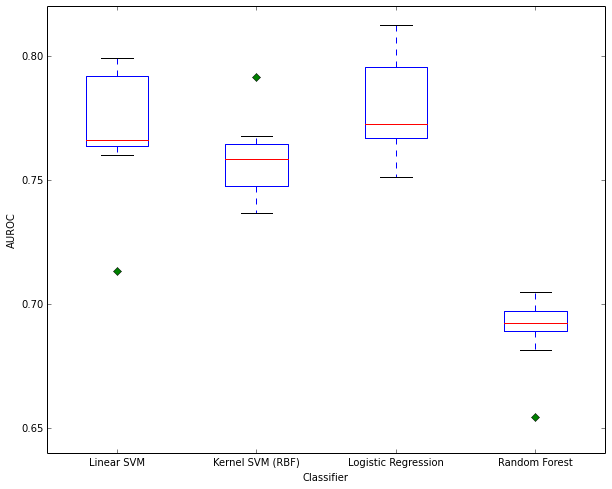

In [4]:
data = np.vstack((linear_svm, rbf, lr, rf)).T

aucs = [results[clf] for clf in results]
data = np.array(aucs).T
xlabels = [clf for clf in results]

plt.figure(figsize=(10, 8))
plt.boxplot(data, 0, 'gD')
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3, 4], xlabels)
plt.show()

# Hospital length of stay

In [6]:
query_output = pd.read_csv('./basic-icu-patient-features.csv').dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes

features = ['age_icu_in', 'icu_los', 'heartrate_min', \
            'heartrate_max', 'meanbp_min', 'meanbp_max', 'resprate_min', 'resprate_max',
            'gender', 'first_careunit']
X = query_output.loc[:, features] 
y = query_output['hosp_los']
mortality = query_output['hospital_expire_flag'].replace(0, -1)

#X.to_csv('./basic-features.csv', index=False, header=False, sep=' ')
#y.to_csv('./basic-labels.csv', index=False)
X.head()

,age_icu_in,icu_los,heartrate_min,heartrate_max,meanbp_min,meanbp_max,resprate_min,resprate_max,gender,first_careunit
0,35.476455,4.2567,75.0,131.0,75.000000,131.000000,14.0,22.0,0,2
1,48.917320,4.9776,86.0,136.0,77.333298,128.667007,9.0,29.0,0,2
2,73.823462,4.0998,55.0,111.0,63.000000,129.000000,9.0,27.0,0,3
3,60.799222,2.4908,46.0,92.0,50.000000,82.000000,0.0,37.0,1,1
4,21.504107,11.5029,68.0,142.0,-17.000000,150.000000,0.0,45.0,1,4


In [28]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = RegressionLabels(np.array(y[:split]))
y_test = RegressionLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 14133)
('Number of testing samples:', 6058)


In [17]:
%%time

# Load models
ls = LeastSquaresRegression(X_train, y_train)

tau = 1
rr = LinearRidgeRegression(tau, X_train, y_train)

width = 1
tau = 1
kernel = GaussianKernel(X_train, X_train, width)
kernel.set_normalizer(SqrtDiagKernelNormalizer())
krr = KernelRidgeRegression(tau, kernel, y_train)

# Train
ls.train()
rr.train()
#krr.train()

metric = MeanSquaredError()

y_pred = ls.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Least square regression MSE:", mse)
y_pred = rr.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Linear ridge regression MSE:", mse)
#y_pred = krr.apply_regression(X_test)
#mse = metric.evaluate(y_pred, y_test)
#print("Kernel ridge regression MSE:", mse)

('Least square regression MSE:', 73.82660524615254)
('Linear ridge regression MSE:', 73.82659141790378)
CPU times: user 208 ms, sys: 24 ms, total: 232 ms
Wall time: 94.5 ms


## Using stratified cross-validation

In [10]:
%%time

features = RealFeatures(np.array(X))
labels = RegressionLabels(np.array(y))

# Parameters to svm
k = 10
split = CrossValidationSplitting(labels, k)

metric = ROCEvaluation()
split.build_subsets()

classifiers = {'LSR': LeastSquaresRegression(), 'LLR': LinearRidgeRegression()}
tau = 1

print("Evaluating classifiers...")
for clf in classifiers:
    mses = []
    for i in range(k):    
        train_idx = split.generate_subset_inverse(i)
        test_idx = split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = RegressionLabels(np.array(y.loc[train_idx]))    
        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = RegressionLabels(np.array(y.loc[test_idx]))

        if clf == 'LLR':
            classifiers[clf].set_tau(tau)
        
        classifiers[clf].set_features(X_train)
        classifiers[clf].set_labels(y_train)
        #ls = LeastSquaresRegression(X_train, y_train)
        
        classifiers[clf].train()

        metric = MeanSquaredError()

        y_pred = classifiers[clf].apply_regression(X_test)
        mse = metric.evaluate(y_pred, y_test)
        print("Fold %d, Least square regression MSE:" % i, mse)
        mses.append(mse)

    print('%s, Mean MSE across all folds:' % clf, np.mean(mses))

Evaluating classifiers...
('Fold 0, Least square regression MSE:', 68.38284847745093)
('Fold 1, Least square regression MSE:', 4145.983440969604)
('Fold 2, Least square regression MSE:', 96.71297639701467)
('Fold 3, Least square regression MSE:', 72.83381998854215)
('Fold 4, Least square regression MSE:', 136.96631956080307)
('Fold 5, Least square regression MSE:', 98.05109749324077)
('Fold 6, Least square regression MSE:', 86.11715259297503)
('Fold 7, Least square regression MSE:', 84.80133242871082)
('Fold 8, Least square regression MSE:', 72.94459705222789)
('Fold 9, Least square regression MSE:', 73.77402433360292)
('LLR, Mean MSE across all folds:', 493.6567609294172)
('Fold 0, Least square regression MSE:', 68.38287630567017)
('Fold 1, Least square regression MSE:', 4145.901996499829)
('Fold 2, Least square regression MSE:', 96.71297981445292)
('Fold 3, Least square regression MSE:', 72.83385172356908)
('Fold 4, Least square regression MSE:', 136.96629101581607)
('Fold 5, Least s

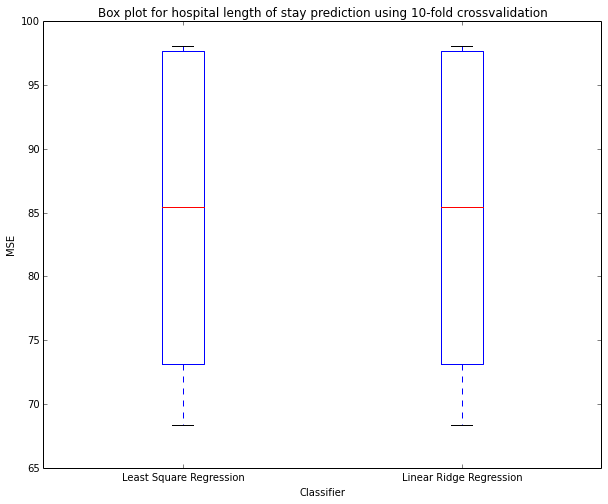

In [9]:
lsr_mse = [68.38284847745093, 4145.983440969604, 96.71297639701467, 72.83381998854215, 136.96631956080307
, 98.05109749324077, 86.11715259297503, 84.80133242871082, 72.94459705222789, 73.77402433360292]


lrr_mse = [68.38287630567017, 4145.901996499829, 96.71297981445292, 72.83385172356908, 136.96629101581607
, 98.05110743222683, 86.11714632988804, 84.8013337491973, 72.94456772903739, 73.77403817572404]

data = np.vstack((lsr_mse, lrr_mse)).T

plt.figure(figsize=(10, 8))
plt.boxplot(data, 0, '')
plt.ylabel('MSE')
plt.xlabel('Classifier')
plt.xticks([1, 2], ['Least Square Regression', 'Linear Ridge Regression'])
plt.title('Box plot for hospital length of stay prediction using 10-fold crossvalidation')
plt.show()